In [1]:
trace_file = 'trace_mpi_0.csv'
archive = 'grenoble_2018-10-24_1813273.zip'

## Simulation

In [2]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def read_mpi_state(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function'],
                  filter_func=lambda x: filter_pajeng(x, 'State'))
    df['rank'] = df['rank'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['function'] = df['function'].str.replace('PMPI', 'MPI')  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    return df

def read_mpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'key'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['remote'] = ((df['src']-1) // 32) != ((df['dst']-1) // 32)
    return df

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
df_state = read_mpi_state(archive, trace_file)
df_state.head()

,type,rank,container,start,end,duration,level,function
0,State,99,MPI_STATE,0.000000,0.000000,0.000000,0.0,MPI_Init
1,State,99,MPI_STATE,0.000000,0.000009,0.000009,0.0,computing
2,State,99,MPI_STATE,0.000009,0.000011,0.000002,0.0,MPI_Recv
3,State,99,MPI_STATE,0.000011,0.000013,0.000002,0.0,computing
4,State,99,MPI_STATE,0.000013,0.000013,0.000000,0.0,MPI_Send


In [4]:
df_link  = read_mpi_link(archive, trace_file)
df_link.head()

,type,level,container,start,end,duration,commType,src,dst,key,remote
0,Link,0,MPI_LINK,0.000007,0.000008,0.000001,PTP,254,253,NaN,False
1,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,234,233,NaN,False
2,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,250,249,NaN,False
3,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,240,239,NaN,False
4,Link,0,MPI_LINK,0.000007,0.000009,0.000002,PTP,256,255,NaN,False


In [5]:
def draw_plot(state_dataframe, link_dataframe, time_interval=None, ranks=None):
    if time_interval is None:
        time_interval = -float('inf'), float('inf')
        time_str = 'for the whole experiment'
    else:
        time_str = 'between %.1fs and %.1fs' % time_interval
    if ranks is None:
        ranks = range(0, 1000000)
        rank_str = 'for all the ranks'
    else:
        rank_str = 'for ranks in %s' % ranks
    tmp_state = state_dataframe[(state_dataframe['start'] >= time_interval[0]) & (state_dataframe['end'] <= time_interval[1]) & (state_dataframe['rank'].isin(ranks))].copy()
    tmp_state['rank+1'] = tmp_state['rank'] + 1
    tmp_link = link_dataframe[(link_dataframe['start'] >= time_interval[0]) & (link_dataframe['end'] <= time_interval[1]) & (link_dataframe['src'].isin(ranks)) & (link_dataframe['dst'].isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme() + ggtitle('Events %s %s' % (time_str, rank_str))
    for i in set(((tmp_state['rank'] - 1) // 32)*32 + 1):
        if i == 1:
            continue
        gc += geom_hline(yintercept=i, linetype='dashed', color='red')
    print(gc)
    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst', color='remote'), arrow = arrow(length = 0.1))
    print(gc)

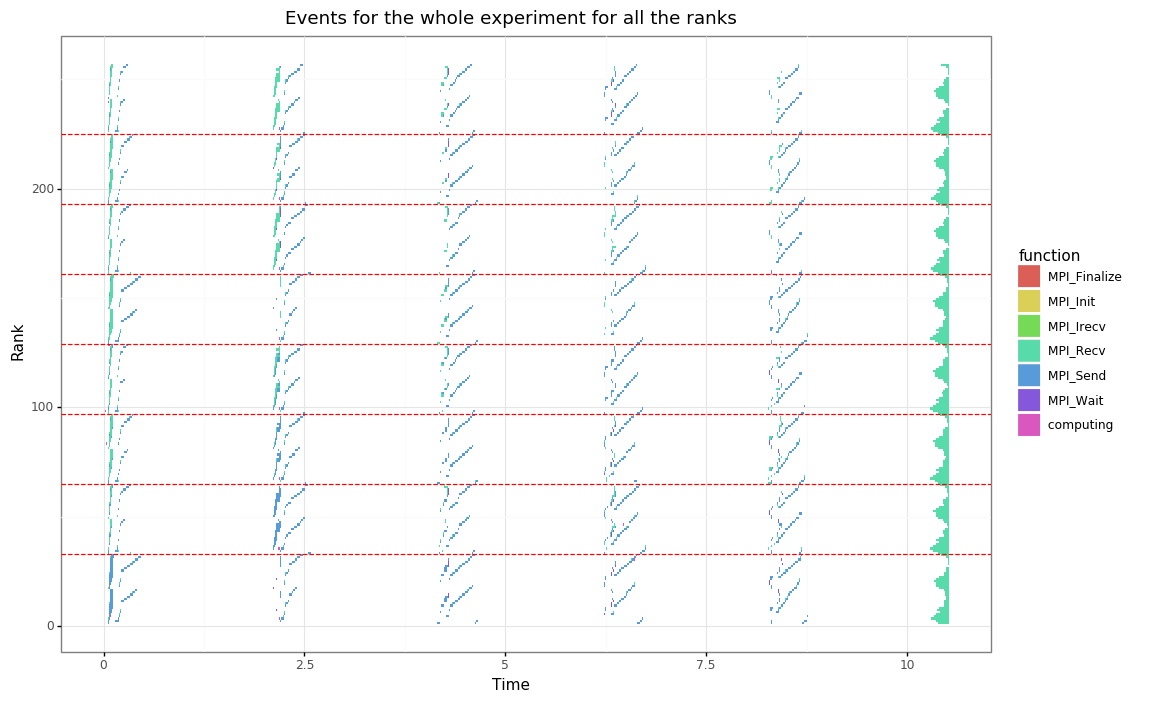

<ggplot: (8766458165494)>


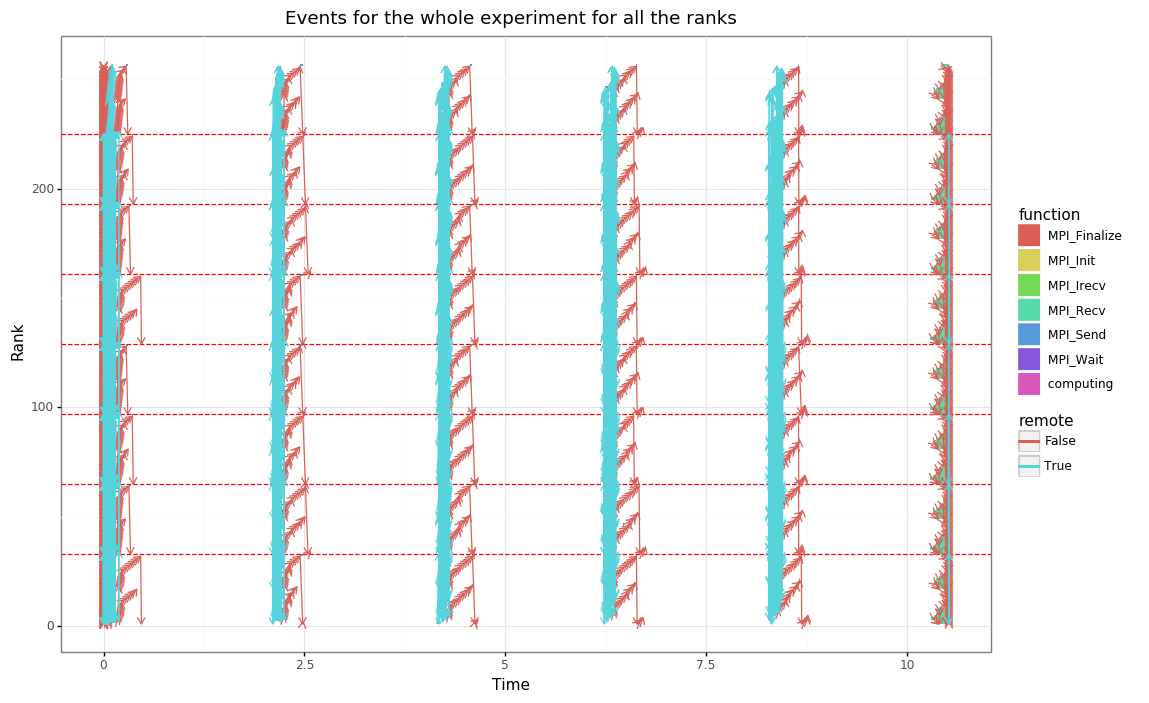

<ggplot: (8766458165494)>


In [6]:
draw_plot(df_state, df_link)

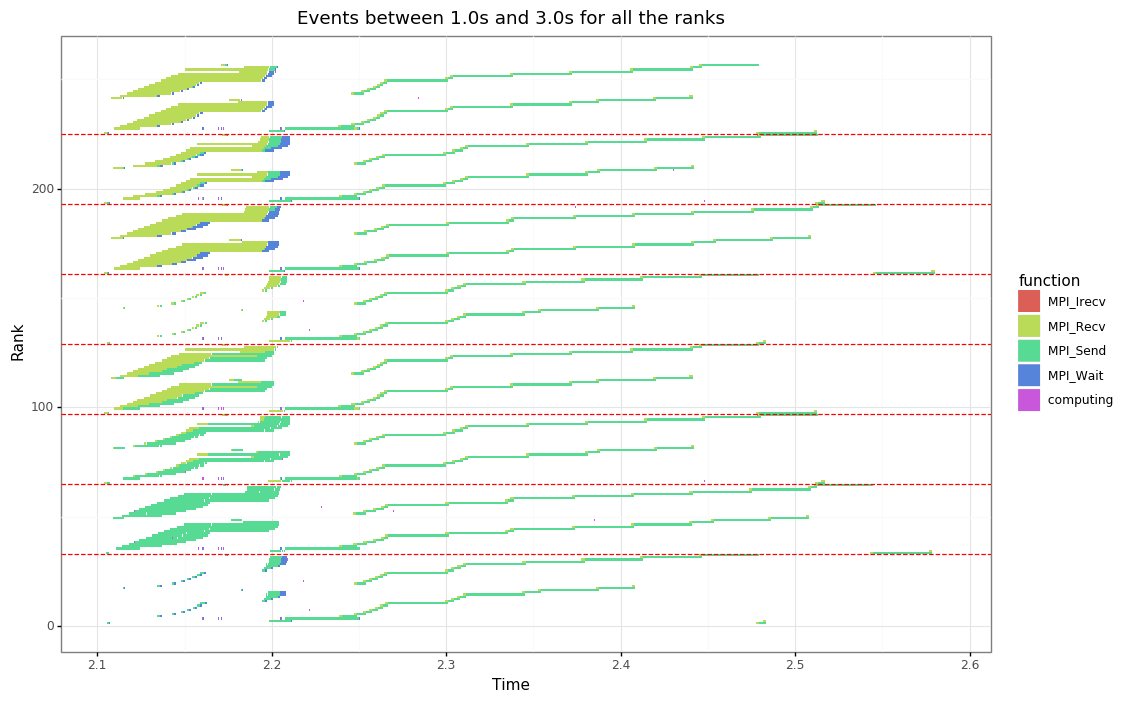

<ggplot: (8766458163120)>


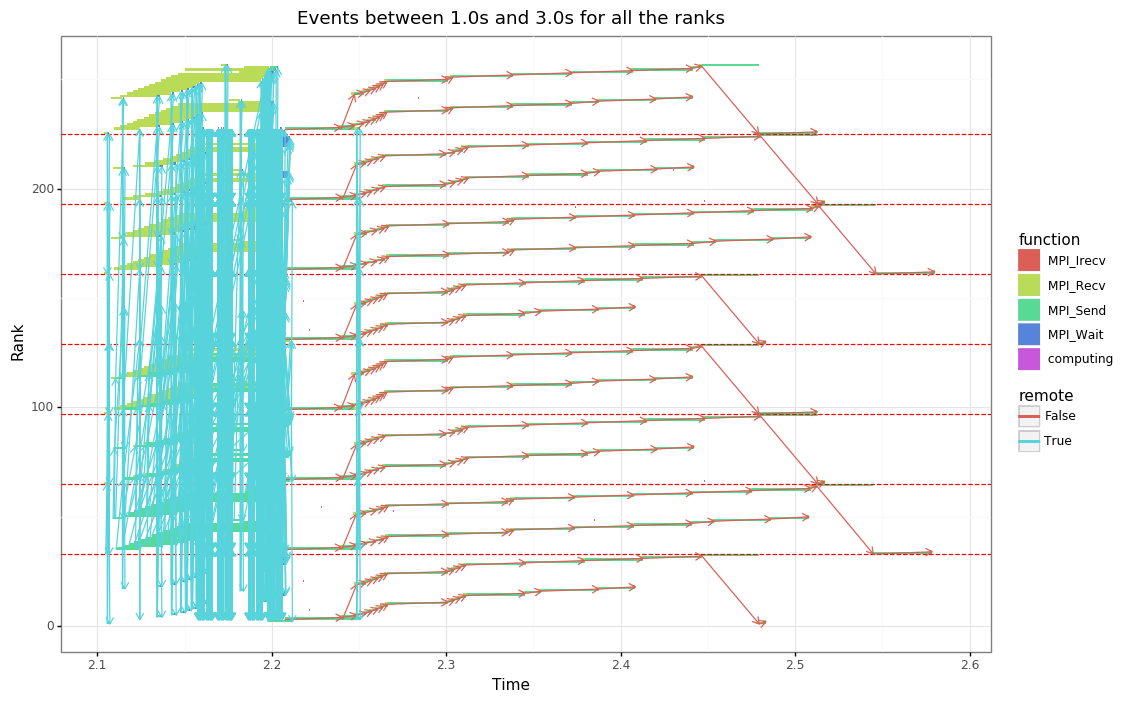

<ggplot: (8766458163120)>


In [7]:
draw_plot(df_state, df_link, time_interval=(1, 3))

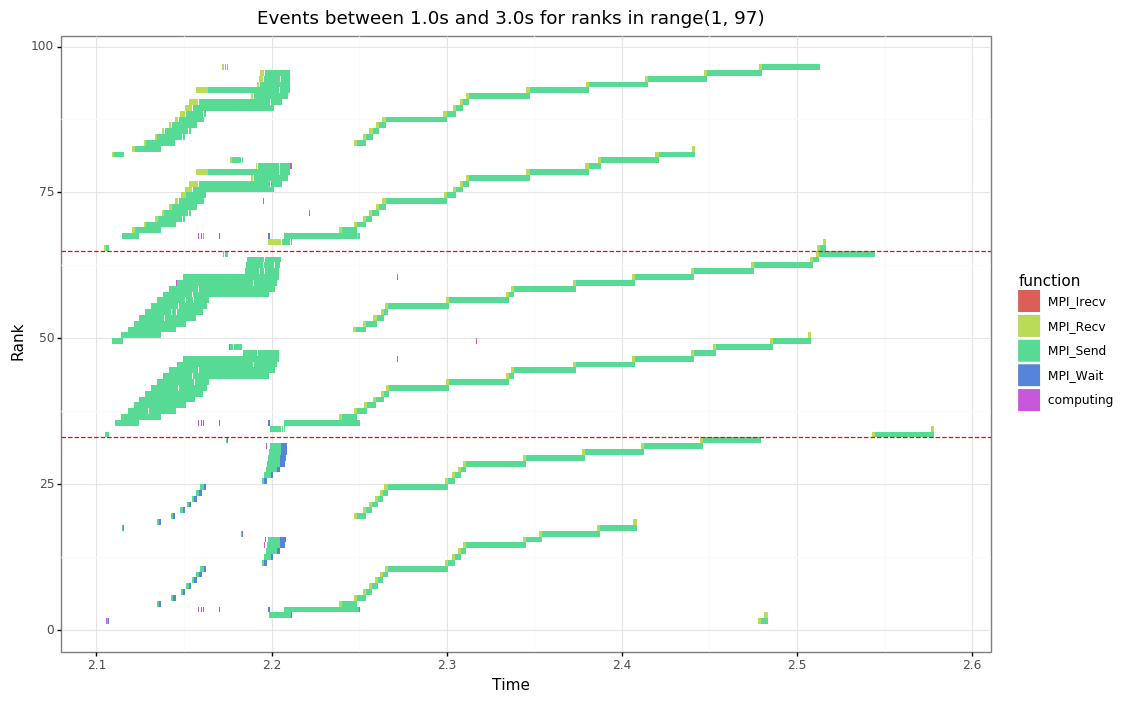

<ggplot: (8766457787389)>


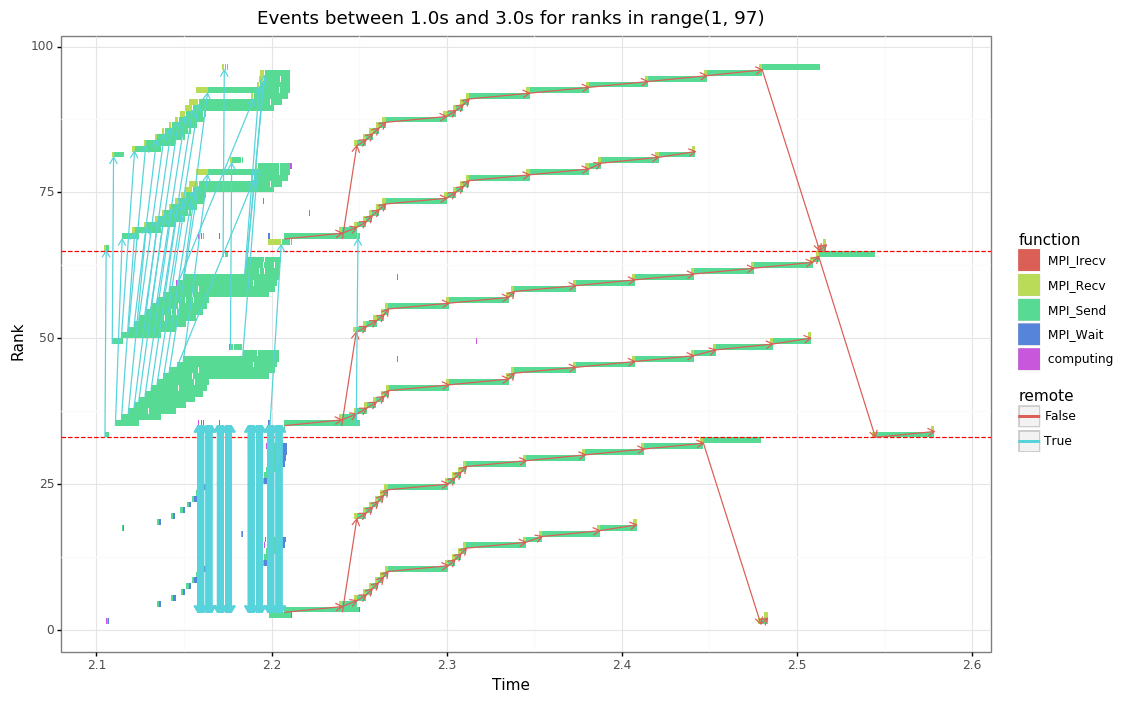

<ggplot: (8766457787389)>


In [8]:
draw_plot(df_state, df_link, time_interval=(1, 3), ranks=range(1, 97))